# 4. Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import plotly.plotly as py
import plotly.graph_objs as go
from collections import Counter
from statistics import stdev, mean
import operator 

In [2]:
#using the defined function in another notebooks
import nbimporter
from exploratory_data_analysis import getColumns

Importing Jupyter notebook from exploratory_data_analysis.ipynb


In [3]:
#target_col = 'Percentage Standard Exceeded'
target_col = 'Percentage Standard Not Met'

## Data Load

We loaded the school data for the independent variables. 
We have selected the important features in the exploratory data analysis section.

The aim is to predict the inferior scores, percentage of the standard "NOT" met, of schools.
Based on these prediction models, we can 1) identify the schools that need help and 2) obtain important features affecting the lower scores of schools. 

In [4]:
# %store -r final_data
# %store -r df_schools
# %store -r studentGroup_types
# %store -r attr_important_features
# %store -r attr_important_features_inter

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
final_data = pd.read_csv('final_school_data.csv', sep='\t', encoding='utf-8')
final_data.drop("Unnamed: 0", axis=1, inplace=True)

In [7]:
df_schools = pd.read_csv('df_schools.csv', sep='\t', encoding='utf-8')
df_schools.drop("Unnamed: 0", axis=1, inplace=True)

In [8]:
studentGroup_types = final_data.groupby(["Category", "Student Groups"], as_index=False).mean()
studentGroup_types = studentGroup_types.loc[:, ["Category", "Student Groups"]]

In [9]:
attr_important_features = pd.read_csv('attr_important_features.csv', sep='\t', encoding='utf-8')
attr_important_features.drop("Unnamed: 0", axis=1, inplace=True)
attr_important_features = attr_important_features['feature'].tolist()

In [10]:
attr_important_features_inter = pd.read_csv('attr_important_features_inter.csv', sep='\t', encoding='utf-8')
attr_important_features_inter.drop("Unnamed: 0", axis=1, inplace=True)
attr_important_features_inter = attr_important_features_inter['feature_inter'].tolist()

In [11]:
def Diff(li1, li2): 
    list_diff = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return list_diff 

#features_diff = Diff(X.columns.tolist(), attr_important_features) 

## Regression

Supervised Learning

In the regression, we use the `Target_Avg_Percentage Standard Not Met` variable as a target variable. 

In [12]:
#independent columns
#delete: Keywords
X = df_schools.drop(getColumns(df_schools, ["English", "Mathematics", "Target", "Rank", "NeedHelp"], "OR"), axis=1)
X_Num = df_schools.drop(getColumns(df_schools, ["Pct", "English", "Mathematics"], "OR"), axis=1)
X_Pct = df_schools.drop(getColumns(df_schools, ["Num", "English", "Mathematics"], "OR"), axis=1)
X_feat = df_schools[attr_important_features_inter]

#delete: specific column name
X = X.drop(['School Code'], axis=1)
X_Num = X_Num.drop(['School Code'], axis=1)
X_Pct = X_Pct.drop(['School Code'], axis=1)

X_all = X.copy()
X_all_Num = X_Num.copy()
X_all_Pct = X_Pct.copy()
# #Include
# X = X[getColumns(X, ["Avg"])]

#target column 
#y = df_schools.iloc[:,-1]
#round(0) for chi square analysis
target_var_name = "Target_Avg_"+target_col
#X = X.drop([target_var_name], axis=1)
X_feat = X_feat.drop([target_var_name], axis=1)
y = df_schools[target_var_name].round(0)

#Data
print("Number of data: ", X.shape[0])
#y = y.astype('float64') # Your y is of type object, so sklearn cannot recognize its type. 
print("Independent variables (size:{})".format(X.columns.size))
print(X.columns)  #attr_important_features = X.columns
#attr_important_features_inter
print("Target variable: ", target_var_name)

#save
reg_name = []
reg_result = []

Number of data:  8768
Independent variables (size:42)
Index(['Pct_Avg_Multi_Ethnicity_Asian+White',
       'Num_Avg_Multi_Ethnicity_Asian+White',
       'Pct_Avg_Multi_Ethnicity_Hispanic+Black',
       'Num_Avg_Multi_Ethnicity_Hispanic+Black',
       'Pct_Avg_Multi_Ethnicity_Minors', 'Num_Avg_Multi_Ethnicity_Minors',
       'Num_Avg_All Students_All Students',
       'Num_Avg_Disability Status_Students with disability',
       'Num_Avg_Disability Status_Students with no reported disability',
       'Num_Avg_Economic Status_Economically disadvantaged',
       'Num_Avg_Economic Status_Not economically disadvantaged',
       'Num_Avg_Ethnicity_Asian',
       'Num_Avg_Ethnicity_Black or African American',
       'Num_Avg_Ethnicity_Filipino', 'Num_Avg_Ethnicity_Hispanic or Latino',
       'Num_Avg_Ethnicity_White', 'Num_Avg_Gender_Female',
       'Num_Avg_Gender_Male', 'Num_Avg_Migrant_Migrant education',
       'Num_Avg_Parent Education_College graduate',
       'Num_Avg_Parent Education_G

### Linear Regression

#### Evaluation metrics

https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-2-regression-metrics-d4a1a9ba3d74

- Mean Absolute Error (MAE): MAE is the mean of the absolute value of the errors. 
- Root Mean Squared Error (RMSE): RMSE is the square root of the mean of the squared errors
- R$^{2}$: R$^{2}$ is the number that indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. Basically, R$^{2}$ represents how accurate our model is. R$^{2}$ shows how well terms (data points) fit a curve or line. Adjusted R$^{2}$ also indicates how well terms fit a curve or line, but adjusts for the number of terms in a model. 


#### Cross Validation

We need to split the data into training and testing sets, fitted a regression model to the training data, made predictions based on this data and tested the predictions on the test data. 

However, the train/test split technique takes to one extreme, $K$ may be set to 1 such that a single train/test split is created to evaluate the model. Thus, the **train/test split technique is not stable in that it may not split the data randomly and the data can be selected only from specific groups.** This will result in overfitting.

The Leave One Out Cross Validation (LOOCV) takes to another extreme, $K$ may be set to the total number of observations in the dataset such that each observation is given a chance to be the held out of the dataset. This is called leave-one-out cross-validation, or LOOCV for short. However, **LOO requires quite a large computation time.**

**Therefore, we the cross validations: K-Fold.** This cross validation is enoguh and appropriate for our model prediction.

Reference:

Train/Test Split and Cross Validation in Python:
https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6  
https://scikit-learn.org/stable/modules/cross_validation.html

* Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=5)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6137, 42) (6137,)
(2631, 42) (2631,)


We provide the coefficients of the regresssion model. 
We sorted the coefficients in an descending order of absolute values.

In [14]:
from sklearn.linear_model import LinearRegression

name = "Linear Regression"
cv_name = "Train and test split"
n_splits = 1

model = LinearRegression()
model.fit(X_train, y_train)

print("Model: {}, Cross Validation: {}, Number splits: {}".format(name, cv_name, n_splits))

coeff_df = pd.DataFrame((model.coef_).round(2), X.columns, columns=['Coefficient'])  
coeff_df.loc[coeff_df['Coefficient'].abs().sort_values(ascending=False).index]
#print('Estimated intercept coefficient: {}'.format(model.intercept_))
#print('Coefficients: {}'.format(model.coef_))    

Model: Linear Regression, Cross Validation: Train and test split, Number splits: 1


,Coefficient
Num_Avg_All Students_All Students,1.33
Num_Avg_Ethnicity_Black or African American,1.18
Num_Avg_Ethnicity_Hispanic or Latino,1.15
Num_Avg_Gender_Male,-1.15
Num_Avg_Multi_Ethnicity_Hispanic+Black,-1.14
Num_Avg_Gender_Female,-1.09
Num_Avg_Ethnicity_Asian,1.03
Num_Avg_Ethnicity_White,1.03
Num_Avg_Multi_Ethnicity_Asian+White,-1.01
Pct_Avg_Parent Education_College graduate,-0.53


In [15]:
y_pred = model.predict(X_test)
df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_result.head()

,Actual,Predicted
238,2.0,1.223690
2290,22.0,25.392595
2095,31.0,38.453762
7776,40.0,35.315899
4355,38.0,46.979242


In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

score_rmse = []
score_mae = []
score_r2 = []

score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
score_mae.append(mean_absolute_error(y_test, y_pred))
score_r2.append(r2_score(y_test, y_pred))

print("\n**Results**")
print("Model: {}, Cross Validation: {}, Number splits: {}".format(name, cv_name, n_splits))

print(f'Root Mean Squared Error(RMSE): {np.mean(score_rmse): 0.4f}, Mean Absolute Error(MAE): {np.mean(score_mae): 0.4f}, R^2 score: {np.mean(score_r2): 0.4f}')  

#save
reg_name.append(name + " with " + str(n_splits) + " folds " + cv_name)
reg_result.append(('%.4f' %np.mean(score_rmse), '%.4f' %np.mean(score_mae), '%.4f' %np.mean(score_r2)))


**Results**
Model: Linear Regression, Cross Validation: Train and test split, Number splits: 1
Root Mean Squared Error(RMSE):  11.2600, Mean Absolute Error(MAE):  8.1919, R^2 score:  0.6629


* Leave One Out (LOO)

Please be cautious for getting a score of zero using cross val score when using the cross validation of Leave One Out.
https://stackoverflow.com/questions/50605956/getting-a-score-of-zero-using-cross-val-score

In [17]:
from sklearn.model_selection import LeaveOneOut

scoring_reg = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

loo = LeaveOneOut()
n_splits = loo.get_n_splits(X) #all samples

name = "Linear Regression"
cv_name = "Leave One Out (LOO)"
model = LinearRegression()

scores = cross_validate(model, X, y, cv=loo, scoring=scoring_reg)

print("\n**Results**")
print("Model: {}, Cross Validation: {}, Number splits: {}".format(name, cv_name, n_splits))

rmse = (-1*mean(scores['test_neg_mean_squared_error']))**0.5
mae = -1*mean(scores['test_neg_mean_absolute_error'])
r2 = mean(scores['test_r2'])

print(f'Root Mean Squared Error(RMSE): {rmse: 0.4f}, Mean Absolute Error(MAE): {mae: 0.4f}')

#save
reg_name.append(name + " with " + str(n_splits) + " folds " + cv_name)
reg_result.append(('%.4f' %rmse, '%.4f' %mae, '%.4f' %r2))


**Results**
Model: Linear Regression, Cross Validation: Leave One Out (LOO), Number splits: 8768
Root Mean Squared Error(RMSE):  11.3252, Mean Absolute Error(MAE):  8.2698


* K-Fold Cross Validation

https://machinelearningmastery.com/k-fold-cross-validation/

cross_val_predict vs. cross_val_score:  
https://stackoverflow.com/questions/43613443/difference-between-cross-val-score-and-cross-val-predict

In [18]:
from sklearn.model_selection import KFold

n_splits = 10
seed = 7

print("Cross Validation: {} {} {}{}".format(cv_name, "(K =", n_splits, ")"))
kfold = KFold(n_splits=n_splits, random_state=seed) # Define the split 

Cross Validation: Leave One Out (LOO) (K = 10)


In [19]:
name = "Linear Regression"
cv_name = "K folds"
model = LinearRegression()

score_rmse = []
score_mae = []
score_r2 = []

print("\n**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Number splits: {}".format(name, cv_name, "(K =", n_splits, ")", n_splits))


for train_index, test_index in kfold.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    model.fit(X_train, y_train)    
    
    y_pred = model.predict(X_test)
    df_regression = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_r2.append(r2_score(y_test, y_pred))

print(f'Root Mean Squared Error(RMSE): {np.mean(score_rmse): 0.4f}, Mean Absolute Error(MAE): {np.mean(score_mae): 0.4f}, R^2 score: {np.mean(score_r2): 0.4f}')    


**Results**
Model: Linear Regression, Cross Validation: K folds (K = 10), Number splits: 10
Root Mean Squared Error(RMSE):  11.3510, Mean Absolute Error(MAE):  8.5309, R^2 score:  0.6249


We can use the `cross_validate` instead the above multiple tedious methods.

In [20]:
name = "Linear Regression"
cv_name = "K folds"
model = LinearRegression()

scores = cross_validate(model, X, y, cv=kfold, scoring=scoring_reg)

print("\n**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Number splits: {}".format(name, cv_name, "(K =", n_splits, ")", n_splits))

rmse = (-1*mean(scores['test_neg_mean_squared_error']))**0.5
mae = -1*mean(scores['test_neg_mean_absolute_error'])
r2 = mean(scores['test_r2'])

print(f'Root Mean Squared Error(RMSE): {rmse: 0.4f}, Mean Absolute Error(MAE): {mae: 0.4f}, R^2 score: {r2: 0.4f}')

#save
reg_name.append(name + " with " + str(n_splits) + " folds CV")
reg_result.append(('%.4f' %rmse, '%.4f' %mae, '%.4f' %r2))


**Results**
Model: Linear Regression, Cross Validation: K folds (K = 10), Number splits: 10
Root Mean Squared Error(RMSE):  11.7057, Mean Absolute Error(MAE):  8.5309, R^2 score:  0.6249


Text(0, 0.5, 'Predicted values')

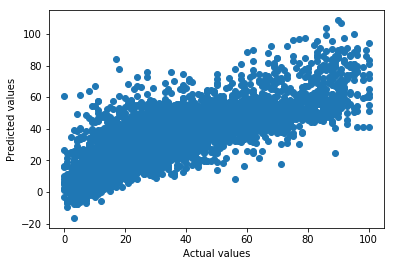

In [21]:
y_pred = cross_val_predict(model, X, y, cv=kfold)
plt.scatter(y, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

In [22]:
pd.DataFrame({'Actual': y, 'Prediction': y_pred}).head() #8768 rows

,Actual,Prediction
0,37.0,22.723963
1,5.0,8.278336
2,31.0,32.826800
3,18.0,53.091717
4,44.0,41.190573


**sklearn vs. stats** 

In the above, we use the `scikit-learn` libraries. In `scikit-learn`, summary statistics must be done by hand. In contrast, computing summary statistics is done automatically in `statsmodels`.    

`statsmodels` has advantage of providing statistical summary (like t score, p-values) for all predictors and for intercept. The `scikit-learn` does not have this feature.  

The `scikit-learn` has advantage in terms of writing the equation. In `scikit-learn`, we just need to split the data to get features (X) and labels (y), and provide X and y as input. In short, `scikit-learn` pretty much just provides the the predicted values and the estimates of the regression coefficients.  
In case of `statsmodels`, we need to explicitly write the expression.

https://datatofish.com/statsmodels-linear-regression/

In [23]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import OLS

In [24]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                                      OLS Regression Results                                      
Dep. Variable:     Target_Avg_Percentage Standard Not Met   R-squared:                       0.670
Model:                                                OLS   Adj. R-squared:                  0.668
Method:                                     Least Squares   F-statistic:                     431.4
Date:                                    Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                                            11:33:01   Log-Likelihood:                -33650.
No. Observations:                                    8768   AIC:                         6.738e+04
Df Residuals:                                        8726   BIC:                         6.768e+04
Df Model:                                              41                                         
Covariance Type:                                nonrobust                                         
          

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



### Random Forest Regressor, Gradient Boosting Regressor, Support Vector Regression

- Random forest regressor:   
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if `bootstrap=True` (default).

- Gradient Boosting for regression:  
GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

- Support Vector Regression:  
The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples. 
For large datasets consider using `sklearn.linear_model.LinearSVR` or `sklearn.linear_model.SGDRegressor` instead, possibly after a `sklearn.kernel_approximation.Nystroem` transformer.

In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

cv_name = "K folds"

models = {
 'Random Forest Regressor': RandomForestRegressor(n_estimators=50, random_state=0),
 'Gradient Boosting for Regression': GradientBoostingRegressor(max_depth=1, random_state=0),
 #'Support Vector Regression': SVR(kernel='linear') #too much complex with over 8700 samples
}

for name, model in models.items():
    scores = cross_validate(model, X, y, cv=kfold,
                            scoring=scoring_reg)
    print("\n**Results**")
    print("Model: {}, Cross Validation: {} {} {}{}, Number splits: {}".format(name, cv_name, "(K =", n_splits, ")", n_splits))

    rmse = (-1*mean(scores['test_neg_mean_squared_error']))**0.5
    mae = -1*mean(scores['test_neg_mean_absolute_error'])
    r2 = mean(scores['test_r2'])  
    print(f'Root Mean Squared Error(RMSE): {rmse: 0.4f}, Mean Absolute Error(MAE): {mae: 0.4f}, R^2 score: {r2: 0.4f}')
    
    reg_name.append(name + " with " + str(n_splits) + " folds CV")
    reg_result.append(('%.4f' %rmse, '%.4f' %mae, '%.4f' %r2))
    
#Results with LOO:  
#RFR RMSE:  0.5301, MAE:  0.3253  
#GBR RMSE:  2.2447, MAE:  1.6408 


**Results**
Model: Random Forest Regressor, Cross Validation: K folds (K = 10), Number splits: 10
Root Mean Squared Error(RMSE):  10.7672, Mean Absolute Error(MAE):  7.6985, R^2 score:  0.6761

**Results**
Model: Gradient Boosting for Regression, Cross Validation: K folds (K = 10), Number splits: 10
Root Mean Squared Error(RMSE):  11.4108, Mean Absolute Error(MAE):  8.3881, R^2 score:  0.6368


### Results of Regression

In [26]:
print("Model Accuracy Results:")
for res in reg_result:
    print(reg_name[reg_result.index(res)], ":", "RMSE: ", res[0], ", MAE: ", res[1], ", R^2: ", res[2])

Model Accuracy Results:
Linear Regression with 1 folds Train and test split : RMSE:  11.2600 , MAE:  8.1919 , R^2:  0.6629
Linear Regression with 8768 folds Leave One Out (LOO) : RMSE:  11.3252 , MAE:  8.2698 , R^2:  0.0000
Linear Regression with 10 folds CV : RMSE:  11.7057 , MAE:  8.5309 , R^2:  0.6249
Random Forest Regressor with 10 folds CV : RMSE:  10.7672 , MAE:  7.6985 , R^2:  0.6761
Gradient Boosting for Regression with 10 folds CV : RMSE:  11.4108 , MAE:  8.3881 , R^2:  0.6368


==> The Random Forest Regressor worked best this time with Root Mean Squared Error(RMSE) 10.7672, Mean Absolute Error(MAE) 7.6985, and R^2 0.6761.

## Classification

We loaded the school data for the independent variables. 
We use the `NeedHelp` variable as a target variable. 
`NeedHelp` indicates that if a school needs a help (1) or not (0).   
**We have labeled schools with more than 80\% of students who do not meet the standard as needing help (1).**

- `NeedHelp` (dependent or response variable)
    - class 1: `Target_Avg_Percentage Standard Not Met` > 80
    - class 0: Otherwise

In [98]:
#independent columns
target_col2='NeedHelp'

X = df_schools.drop(getColumns(df_schools, ["English", "Mathematics", "Target", "Rank"], "OR"), axis=1)
X = X.drop(['School Code'], axis=1)

print("Target variable:", target_col2)
print("Number of instances")
print(target_col2,"== 0: ", len(X.loc[X[target_col2] == 0]))
print(target_col2,"== 1: ", len(X.loc[X[target_col2] == 1]))
pctOneTarget = (len(X.loc[X[target_col2]==1])) / (len(X.loc[X[target_col2]==0])) * 100
print("The percentage of target == 1 over target == 0: ", '%0.2f' % pctOneTarget , "%\n")

#%0.2f' % roc_auc
y = df_schools[target_col2]
X = X.drop([target_col2], axis=1)

#Data
print("Number of data: ", X.shape[0])
print("Independent variables (size:{})".format(X.columns.size))
print(X.columns) 

#Results
clf_name = []
clf_result = []
clf_best = []

clf_name2 = []
clf_best2 = []

Target variable: NeedHelp
Number of instances
NeedHelp == 0:  8456
NeedHelp == 1:  312
The percentage of target == 1 over target == 0:  3.69 %

Number of data:  8768
Independent variables (size:42)
Index(['Pct_Avg_Multi_Ethnicity_Asian+White',
       'Num_Avg_Multi_Ethnicity_Asian+White',
       'Pct_Avg_Multi_Ethnicity_Hispanic+Black',
       'Num_Avg_Multi_Ethnicity_Hispanic+Black',
       'Pct_Avg_Multi_Ethnicity_Minors', 'Num_Avg_Multi_Ethnicity_Minors',
       'Num_Avg_All Students_All Students',
       'Num_Avg_Disability Status_Students with disability',
       'Num_Avg_Disability Status_Students with no reported disability',
       'Num_Avg_Economic Status_Economically disadvantaged',
       'Num_Avg_Economic Status_Not economically disadvantaged',
       'Num_Avg_Ethnicity_Asian',
       'Num_Avg_Ethnicity_Black or African American',
       'Num_Avg_Ethnicity_Filipino', 'Num_Avg_Ethnicity_Hispanic or Latino',
       'Num_Avg_Ethnicity_White', 'Num_Avg_Gender_Female',
       'N

==> We can see we have an imbalanced class: 3.69\% of our dataset belong to the target class `NeedHelp`. We need to deal with this imbalaced classes properly.

#### Evaluation Metrics

https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

- Accuracy
- precison, recall, f1
- AUC

We also measure the accuracy, precision, recall and f1-score.  
We also present the **Receiver Operating Characteristic (ROC)** curve and **Area Under the Curve (AUC)**.

In [28]:
# print("True Positive Rate (TPR): TP/Actual YES = TP/(TP+FN)")
# print("False Positive Rate (FPR): FP/Actual NO = FP/(FP+TN)")
# https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py

def getSetofMetrics(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    print("FP:", FP)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    print("FN:", FN)
    TP = np.diag(cnf_matrix)
    print("TP:", TP)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    print("TN:", TN)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Precision #PPV
    precision = TP/(TP+FP) #positive predictive value
    # Recall #TPR  #true positive rate
    recall = TP/(TP+FN) #sensitivity, hit rate
    # F1
    f1 = 2*((precision*recall)/(precision+recall))
    # false positive rate
    FPR = FP/(FP+TN) #Fall out  
    # false negative rate
    FNR = FN/(TP+FN)    
    # true negative rate
    TNR = TN/(TN+FP) #Specificity    
    # Negative predictive value
    NPV = TN/(TN+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    FP, FN, TP, TN, TNR, NPV, FDR, ACC
    return precision, recall, f1, FPR, FNR

In [29]:
pd.DataFrame(
    [['TN', 'FP'], ['FN', 'TP']],
    columns=['Predicted Not', 'Predicted'],
    index=['True Not', 'True']
)

,Predicted Not,Predicted
True Not,TN,FP
True,FN,TP


### Logistic Regression 

https://stackoverflow.com/questions/37367405/python-scikit-learn-cant-handle-mix-of-multiclass-and-continuous  
https://towardsdatascience.com/how-to-build-a-gender-classifier-in-python-using-scikit-learn-13c7bb502f2e  
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

* Train/Test Split 

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score #see classification metrics: https://scikit-learn.org/stable/modules/classes.html  
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=5)

name = "Logistic Regression"
cv_name = "Train and test split"
n_splits = 1

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n**Results**")
print("Model: {}, Cross Validation: {}, Number splits: {}".format(name, cv_name, n_splits))
print('Classification Report: \n', classification_report(y_test, y_pred), '\n')
# print('Confusion matrix \n', confusion_matrix(y_test, y_pred), '\n')
# precision, recall, f1, FPR, FNR = getSetofMetrics(y_test, y_pred)
# print(precision, recall, f1, FPR, FNR)
#average_precision["micro"] = average_precision_score(y_test, y_pred, average='micro')

precision, recall, fscore, support = score(y_test, y_pred, average='micro')
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F-score   : {:.4f}'.format(fscore))
print('Support   : {}'.format(support))

print(f'Accurcy: {accuracy_score(y_test, y_pred): 0.4f}')
print(f'Precision: {: 0.4f}')
print(f'Recall: {recall_score(y_test, y_pred): 0.4f}')
#print(f'f1-score: {f1_score(y_test, y_pred): 0.4f}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred): 0.4f}')


**Results**
Model: Logistic Regression, Cross Validation: Train and test split, Number splits: 1
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2545
           1       0.42      0.24      0.31        86

   micro avg       0.96      0.96      0.96      2631
   macro avg       0.70      0.62      0.65      2631
weighted avg       0.96      0.96      0.96      2631
 

Precision : 0.9643
Recall    : 0.9643
F-score   : 0.9643
Support   : None
Accurcy:  0.9643
Recall:  0.2442
roc_auc_score:  0.6164


* Stratified K-Folds Cross Validation

To overcome the problem of the imbalanced classes, we used the Stratified K-Folds Cross Validation.
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. In short, the stratification will ensure that the percentages of each class in your entire data will be the same (or very close to) within each individual fold.  
https://stackoverflow.com/questions/32615429/k-fold-stratified-cross-validation-with-imbalanced-classes

In [74]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

def classification_report_with_as(y_true, y_pred):
    print(classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [75]:
cv_name = "Stratified K-Folds CV"
n_splits = 5
seed = 7

#kfold = KFold(n_splits=n_splits, random_state=seed) # Define the split 
print("Stratified K-Folds Cross Validation: {} {} {}{}".format(cv_name, "(K =", n_splits, ")"))
kfold = StratifiedKFold(n_splits=n_splits, random_state=seed) # Define the split 

name = "Logistic Regression"
cv_name = "K folds"
model = LogisticRegression(solver='liblinear')

score_acc = []
score_precision = []
score_recall = []
#score_f1 = []
score_auc = []
k=0

for train_index, test_index in kfold.split(X,y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    model.fit(X_train, y_train)    
    
    y_pred = model.predict(X_test)
    df_logistic = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
   
    try:
        k=k+1
        print("K =", k)
        print("accuracy_score", accuracy_score(y_test, y_pred))
        print("precision_score", precision_score(y_test, y_pred))
        print("recall_score", recall_score(y_test, y_pred))
        #print("f1_score", f1_score(y_test, y_pred))
        print("roc_auc_score", roc_auc_score(y_test, y_pred))
        
        score_acc.append(accuracy_score(y_test, y_pred))
        score_precision.append(precision_score(y_test, y_pred))
        score_recall.append(recall_score(y_test, y_pred))
        #score_f1.append(f1_score(y_test, y_pred))
        score_auc.append(roc_auc_score(y_test, y_pred))

    except ValueError:
        pass
    
    #print(classification_report(y_test, y_pred), '\n')

#     fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
#     print(fpr, tpr, thresholds)
#     score_auc.append(auc(fpr, tpr))


nested_score = cross_val_score(model, X, y, cv=kfold, 
                               scoring=make_scorer(classification_report_with_as))
print(nested_score) 

print("\n**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Number splits: {}".format(name, cv_name, "(K =", n_splits, ")", n_splits))

print(f'Accurcy: {np.mean(score_acc): 0.4f}')
print(f'Precision: {np.mean(score_precision): 0.4f}')
print(f'Recall: {np.mean(score_recall): 0.4f}')
#print(f'f1-score: {np.mean(score_f1): 0.4f}')
print(f'roc_auc_score: {np.mean(score_auc): 0.4f}')
    

Stratified K-Folds Cross Validation: Stratified K-Folds CV (K = 5)
K = 1
accuracy_score 0.9629629629629629
precision_score 0.4782608695652174
recall_score 0.3492063492063492
roc_auc_score 0.6675109760216144
K = 2
accuracy_score 0.9486887115165337
precision_score 0.32
recall_score 0.38095238095238093
roc_auc_score 0.675396356058686
K = 3
accuracy_score 0.9720479178551056
precision_score 1.0
recall_score 0.20967741935483872
roc_auc_score 0.6048387096774194
K = 4
accuracy_score 0.9691956645750143
precision_score 1.0
recall_score 0.12903225806451613
roc_auc_score 0.564516129032258
K = 5
accuracy_score 0.9697661152310325
precision_score 0.7647058823529411
recall_score 0.20967741935483872
roc_auc_score 0.6036559775662426
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1692
           1       0.48      0.35      0.40        63

   micro avg       0.96      0.96      0.96      1755
   macro avg       0.73      0.67      0.69      1755
wei

Here we use the `cross_validate` for automating this process.

In [32]:
scoring_clf = ['accuracy', 'precision', 'recall'] #['f1','roc_auc']

name = "Logistic Regression"
cv_name = "K folds"
model = LogisticRegression(solver='liblinear')


try:
    results = cross_validate(model, X, y, cv=kfold, scoring=scoring_clf)
                         #, error_score='raise-deprecating', return_estimator=True)
except ValueError:
    pass        
        
log_acc = mean(results['test_accuracy'])
#log_f1 =  mean(results['test_f1'])
log_precision =  mean(results['test_precision'])
log_recall =  mean(results['test_recall'])


#print(sorted(results.keys()))

print("**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Number splits: {}".format(name, cv_name, "(K =", n_splits, ")", n_splits))

print(f'Accurcy: {log_acc: 0.4f}, precision: {log_precision: 0.4f}, recall: {log_recall: 0.4f}')

#save
clf_name2.append(name + " with " + str(n_splits) + " folds CV")
clf_best2.append(('%.4f' % mean(results['test_accuracy']), "" )) #results['estimator']

**Results**
Model: Logistic Regression, Cross Validation: K folds (K = 5), Number splits: 5
Accurcy:  0.9645, precision:  0.7126, recall:  0.2557


### Decision Tree

The decision tree classifier iteratively divides the working area (plot) into subpart by identifying lines.
There are three key terms related to decision tree classifiers:

**Criterion**

- Impurity:  
Impurity is when we have a traces of one class division into other.

- Entropy:  
Entropy is a degree of randomness of elements. In other words, it is a measure of impurity. It is the negative summation of probability times the log of the probability of item x.

- Information gain:  
Information Gain (n) = Entropy(x) — ([weighted average] * entropy(children for feature))  
At every stage, a decision tree selects the one that gives the best information gain. An information gain of 0 means the feature does not divide the working set at all.

**Optimizing Decision Tree Performance**  
https://www.datacamp.com/community/tutorials/decision-tree-classification-python

- criterion : optional (default=”gini”) or Choose attribute selection measure: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

- splitter : string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

- max_depth : int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

* Train/Test Split

In [33]:
from sklearn.tree import DecisionTreeClassifier

#Decision Tree
name = "Decision Tree"
cv_name = "Train and test split"
n_splits = 1


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=5)

#criterion='entropy', default='gini'
dtree = DecisionTreeClassifier()
dtree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**Model Fitting and Feature Importances**

In [34]:
dtree.fit(X_train, y_train)
dtree.feature_importances_

array([0.00104215, 0.00698586, 0.02208283, 0.00816703, 0.00547446,
       0.        , 0.00665273, 0.01165615, 0.02767646, 0.01207852,
       0.        , 0.        , 0.0074671 , 0.        , 0.02531173,
       0.        , 0.0332267 , 0.01375203, 0.        , 0.        ,
       0.        , 0.01048892, 0.02402492, 0.        , 0.00187688,
       0.01023766, 0.05097644, 0.02732845, 0.        , 0.01263034,
       0.        , 0.04299571, 0.03384613, 0.41397433, 0.06599257,
       0.        , 0.00995099, 0.        , 0.02503605, 0.0200461 ,
       0.06902076, 0.        ])

**Classification Report**

In [35]:
y_pred = dtree.predict(X_test)
print('\nClassification Report: \n', classification_report(y_test, y_pred), '\n')


Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2545
           1       0.45      0.43      0.44        86

   micro avg       0.96      0.96      0.96      2631
   macro avg       0.71      0.71      0.71      2631
weighted avg       0.96      0.96      0.96      2631
 



**Confusion Matrix**  
https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

In [36]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['[Predicted Not] '+target_col2, '[Predicted] '+target_col2],
    index=['[True Not] '+target_col2, '[True] '+target_col2]
)

,[Predicted Not] NeedHelp,[Predicted] NeedHelp
[True Not] NeedHelp,2499,46
[True] NeedHelp,49,37


**Probability Predictions**  

Another type of prediction you may wish to make is the probability of the data instance belonging to each class.
This is called a probability prediction where given a new instance, the model returns the probability for each outcome class as a value between 0 and 1.

**ROC and AUC**

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [37]:
def getROCAUC(clfObj, name):
    probs = clfObj.predict_proba(X_test) # returns probability estimates for test set 
    y_pred_prob = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.title(name + '\nReceiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

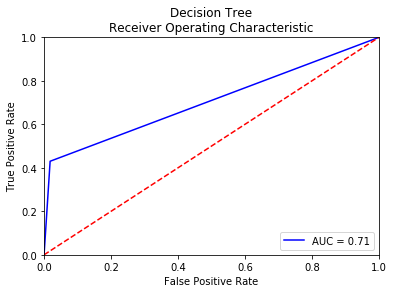

In [38]:
result_auc = getROCAUC(dtree,name)

* K-Fold Cross Validation

In [39]:
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# import warnings
# warnings.filterwarnings('always') 

#Decision Tree
name = "Decision Tree"
cv_name = "K folds"
n_splits = 10
#criterion='entropy', default='gini'
dtree = DecisionTreeClassifier()

results = cross_validate(dtree, X, y, cv=kfold, scoring=scoring_clf, return_estimator=True)
# try:
#     results = cross_validate(model, X, y, cv=kfold, scoring=scoring_clf)
#                          #, error_score='raise-deprecating', return_estimator=True)
# except ValueError:
#     pass        

dtc_acc = mean(results['test_accuracy'])
#dtc_f1 =  mean(results['test_f1'])
dtc_precision =  mean(results['test_precision'])
dtc_recall =  mean(results['test_recall'])

print("\n**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Number splits: {}".format(name, cv_name, "(K =", n_splits, ")", n_splits))
#print(f'Accurcy: {dtc_acc: 0.4f}')
print(f'Accurcy: {dtc_acc: 0.4f}, precision: {dtc_precision: 0.4f}, recall: {dtc_recall: 0.4f}')

clf_name2.append(name + " with " + str(n_splits) + " folds CV")
clf_best2.append(('%.4f' % mean(results['test_accuracy']), "" )) #results['estimator']



**Results**
Model: Decision Tree, Cross Validation: K folds (K = 10), Number splits: 10
Accurcy:  0.9610, precision:  0.5763, recall:  0.5155


### Decision Tree with GridSearchCV for Parameter Tuning

We first split the train and test data. In the train data, we use the k-fold cross validation for finding (tuning) the parameters. After the finding parameter process is finished, we use the remained test data to evaluate the model.

Please note that using the `GridSearchCV` for parameter tuning can be burden in time and computation.
For example, for a model, if we consider 10-fold validation, 3 parameters in which one of each has 5 values, then the model needs to be run 1250 (= 5 * 5 * 5 * 10) times.

![grid_search_cross_validation](grid_search_cross_validation.png)
Image from https://scikit-learn.org/stable/modules/cross_validation.html

In [40]:
# # Create first pipeline for base without reducing features.

# pipe = Pipeline([('classifier' , RandomForestClassifier())])
# # pipe = Pipeline([('classifier', RandomForestClassifier())])

# # Create param grid.

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}
# ]

# # Create grid search object

# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(X_train, y_train)

In [41]:
#result save
def saveClfModelResult(clfObj, name):
    clf_name.append(name)
    clf_result.append(clfObj.cv_results_['mean_test_score'])
    clf_best.append(('%.4f' %clfObj.best_score_, clfObj.best_params_))
    
    clf_name2.append(name)
    clf_best2.append(('%.4f' %clfObj.best_score_, clfObj.best_params_))

In [42]:
from sklearn.model_selection import GridSearchCV

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {
    'max_depth': [50, 75, 100], #list(range(1,5))
    'min_samples_leaf': [1, 2, 4, 8, 10]
}

# K-Fold Cross-Validation
#Decision Tree
name = "Decision Tree with GridSearchCV"
cv_name = "K folds"
dtree = DecisionTreeClassifier()
n_splits = num_folds = 10

# instantiate the grid
dtc_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, scoring='accuracy', return_train_score=False,
                     cv = num_folds, n_jobs = -1)

# scoring = ['accuracy']
# for score in scoring:
#     results = cross_val_score(dtc_grid, X_train, y_train, cv=kfold, scoring=score)
#     print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

# results = cross_val_score(dtc_grid, X_train, y_train, cv=kfold, scoring='accuracy')
# print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

# instantiate and fit the grid
dtc_grid.fit(X_train, y_train)


print("**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Grid Search CV with parameters: {}".format(name, cv_name, "(K =", n_splits, ")", param_grid))

print(pd.DataFrame(dtc_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

y_pred = dtc_grid.predict(X_test)
print('\nClassification Report: \n', classification_report(y_test, y_pred), '\n')

print('\nConfusion Matrix:')
target_col2='NeedHelp'

print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['[Predicted Not] '+target_col2, '[Predicted] '+target_col2],
    index=['[True Not] '+target_col2, '[True] '+target_col2]
))

print("\nBest Accuracy: {:.4f}".format(dtc_grid.best_score_))
print("Best parameters: ", dtc_grid.best_params_)
print("Best model: ", dtc_grid.best_estimator_)

saveClfModelResult(dtc_grid, name)


**Results**
Model: Decision Tree with GridSearchCV, Cross Validation: K folds (K = 10), Grid Search CV with parameters: {'max_depth': [50, 75, 100], 'min_samples_leaf': [1, 2, 4, 8, 10]}
    mean_test_score  std_test_score  \
0          0.967085        0.004411   
1          0.967411        0.005139   
2          0.967900        0.005504   
3          0.968877        0.003130   
4          0.969203        0.002944   
5          0.966759        0.003578   
6          0.968226        0.006265   
7          0.967085        0.005143   
8          0.968714        0.003233   
9          0.968877        0.002454   
10         0.965781        0.007021   
11         0.967737        0.005020   
12         0.968063        0.005747   
13         0.968877        0.003375   
14         0.969203        0.002229   

                                        params  
0     {'max_depth': 50, 'min_samples_leaf': 1}  
1     {'max_depth': 50, 'min_samples_leaf': 2}  
2     {'max_depth': 50, 'min_samples_leaf

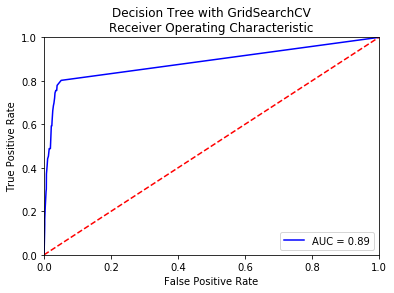

In [43]:
result_auc = getROCAUC(dtc_grid, name)

**Decision Tree Visualization**

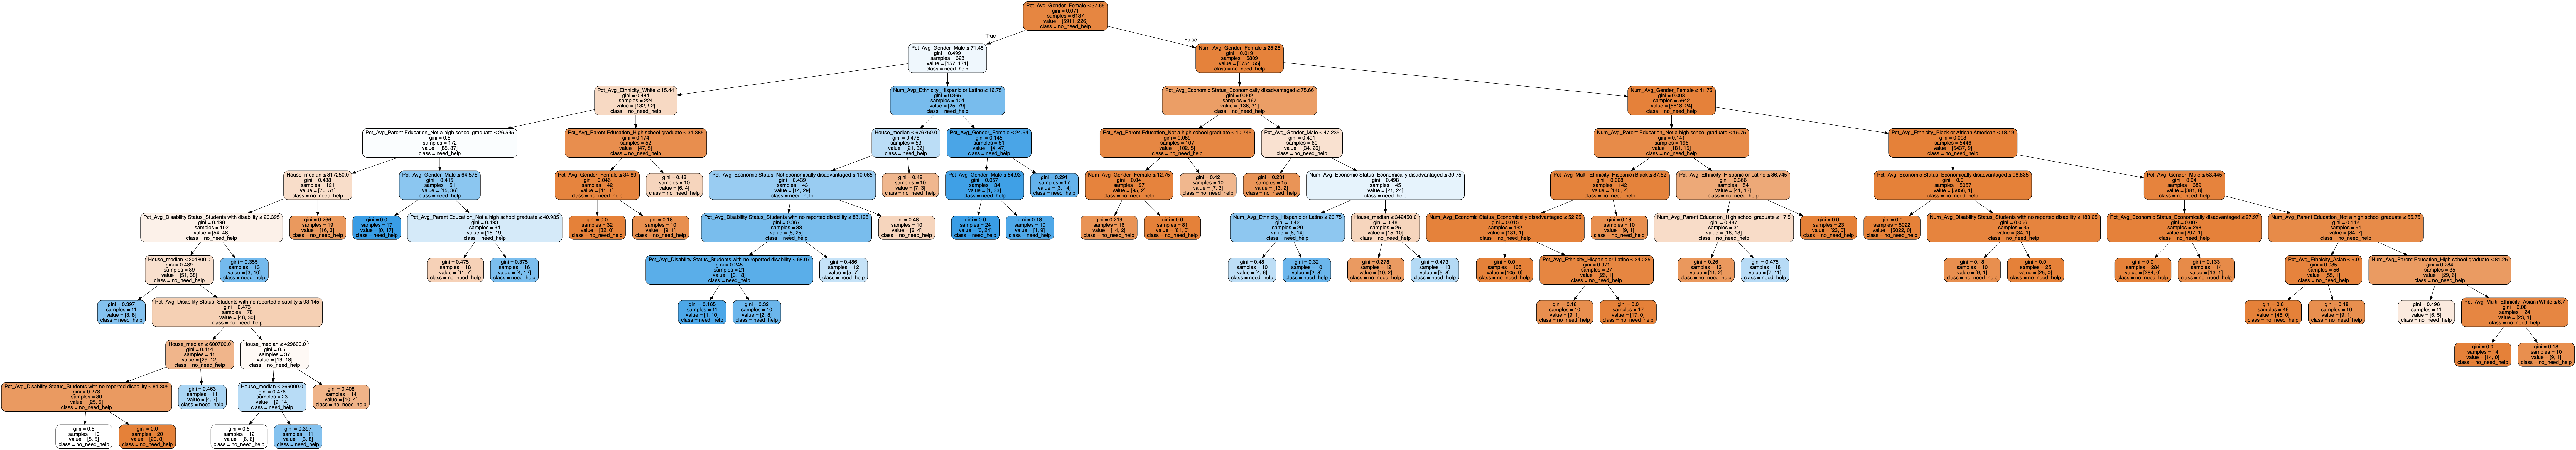

In [44]:
#https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#class_names = ascending order
dot_data = StringIO()
export_graphviz(dtc_grid.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns, class_names=['no_need_help','need_help'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#graph.write_pdf("school.pdf")

In [45]:
# #https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus

# dot_data = StringIO()

# #class_names = ascending order
# export_graphviz(dtree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names=X_train.columns, class_names=['no_need_help','need_help'])

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())
# #graph.write_pdf("school.pdf")

### Random Forest Classifier with GridSearchCV

In [46]:
from sklearn.ensemble import RandomForestClassifier

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth':[100, 150, 200],
    'min_samples_leaf':[1, 2, 4]
}

#Random Forest Classifier
name = "Random Forest Classifier with GridSearchCV"
cv_name = "K folds"
n_splits = num_folds = 10
rfc = RandomForestClassifier()


# instantiate the grid
rfc_grid = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring='accuracy', return_train_score=False,
                     cv = num_folds, n_jobs = -1)

# instantiate and fit the grid
rfc_grid.fit(X_train, y_train)


print("**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Grid Search CV with parameters: {}".format(name, cv_name, "(K =", n_splits, ")", param_grid))

print(pd.DataFrame(rfc_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

y_pred = rfc_grid.predict(X_test)
print('\nClassification Report: \n', classification_report(y_test, y_pred), '\n')

print('\nConfusion Matrix:')
target_col2='NeedHelp'

print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['[Predicted Not] '+target_col2, '[Predicted] '+target_col2],
    index=['[True Not] '+target_col2, '[True] '+target_col2]
))

print("\nBest Accuracy: {:.4f}".format(rfc_grid.best_score_))
print("Best parameters: ", rfc_grid.best_params_)
print("Best model: ", rfc_grid.best_estimator_)

saveClfModelResult(rfc_grid, name)

**Results**
Model: Random Forest Classifier with GridSearchCV, Cross Validation: K folds (K = 10), Grid Search CV with parameters: {'n_estimators': [100, 150, 200], 'max_depth': [100, 150, 200], 'min_samples_leaf': [1, 2, 4]}
    mean_test_score  std_test_score  \
0          0.972625        0.003915   
1          0.972462        0.004578   
2          0.971484        0.004507   
3          0.971810        0.005162   
4          0.972462        0.004639   
5          0.972136        0.004857   
6          0.972136        0.004859   
7          0.973277        0.005173   
8          0.972299        0.003926   
9          0.973766        0.004812   
10         0.970996        0.004369   
11         0.971484        0.004071   
12         0.972462        0.004812   
13         0.971321        0.004072   
14         0.971973        0.005097   
15         0.972299        0.005314   
16         0.973277        0.005166   
17         0.972951        0.003667   
18         0.972299        0.0056

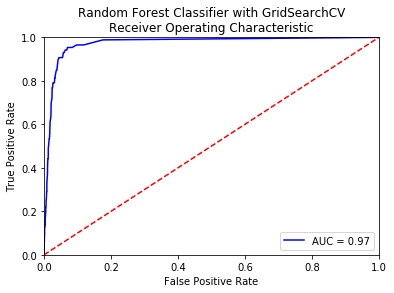

In [47]:
result_auc = getROCAUC(rfc_grid, name)

### SVC (Support Vector Classifier) with GridSearchCV

In [48]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}


#Support Vector Classifier
name = "Support Vector Classifier with GridSearchCV"
cv_name = "K folds"
_splits = num_folds = 10
svc = SVC(kernel='rbf')


# instantiate the grid
svc_grid = GridSearchCV(estimator = svc, param_grid = param_grid, scoring='accuracy', return_train_score=False,
                     cv = num_folds, n_jobs = -1)

# instantiate and fit the grid
svc_grid.fit(X_train, y_train)


print("**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Grid Search CV with parameters: {}".format(name, cv_name, "(K =", n_splits, ")", param_grid))

print(pd.DataFrame(svc_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

y_pred = svc_grid.predict(X_test)
print('\nClassification Report: \n', classification_report(y_test, y_pred), '\n')

print('\nConfusion Matrix:')
target_col2='NeedHelp'

print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['[Predicted Not] '+target_col2, '[Predicted] '+target_col2],
    index=['[True Not] '+target_col2, '[True] '+target_col2]
))

print("\nBest Accuracy: {:.4f}".format(svc_grid.best_score_))
print("Best parameters: ", svc_grid.best_params_)
print("Best model: ", svc_grid.best_estimator_)

saveClfModelResult(svc_grid, name)

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



**Results**
Model: Support Vector Classifier with GridSearchCV, Cross Validation: K folds (K = 10), Grid Search CV with parameters: {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
    mean_test_score  std_test_score                        params
0          0.963174        0.000764  {'C': 0.001, 'gamma': 0.001}
1          0.963174        0.000764   {'C': 0.001, 'gamma': 0.01}
2          0.963174        0.000764    {'C': 0.001, 'gamma': 0.1}
3          0.963174        0.000764      {'C': 0.001, 'gamma': 1}
4          0.963174        0.000764   {'C': 0.01, 'gamma': 0.001}
5          0.963174        0.000764    {'C': 0.01, 'gamma': 0.01}
6          0.963174        0.000764     {'C': 0.01, 'gamma': 0.1}
7          0.963174        0.000764       {'C': 0.01, 'gamma': 1}
8          0.963174        0.000764    {'C': 0.1, 'gamma': 0.001}
9          0.963174        0.000764     {'C': 0.1, 'gamma': 0.01}
10         0.963174        0.000764      {'C': 0.1, 'gamma': 0.1}
11         

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### k-Neighbors Classifier with GridSearchCV

In [49]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': list(range(1,31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


name = "K-Nearest Neighbor with GridSearchCV"
cv_name = "K folds"
_splits = num_folds = 10
knn = KNeighborsClassifier()


# instantiate the grid
knn_grid = GridSearchCV(estimator = knn, param_grid = param_grid, scoring='accuracy', return_train_score=False,
                     cv = num_folds, n_jobs = -1)

# instantiate and fit the grid
knn_grid.fit(X_train, y_train)


print("**Results**")
print("Model: {}, Cross Validation: {} {} {}{}, Grid Search CV with parameters: {}".format(name, cv_name, "(K =", n_splits, ")", param_grid))

print(pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

y_pred = knn_grid.predict(X_test)
print('\nClassification Report: \n', classification_report(y_test, y_pred), '\n')

print('\nConfusion Matrix:')
target_col2='NeedHelp'

print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['[Predicted Not] '+target_col2, '[Predicted] '+target_col2],
    index=['[True Not] '+target_col2, '[True] '+target_col2]
))

print("\nBest Accuracy: {:.4f}".format(knn_grid.best_score_))
print("Best parameters: ", knn_grid.best_params_)
print("Best model: ", knn_grid.best_estimator_)

saveClfModelResult(knn_grid, name)


**Results**
Model: K-Nearest Neighbor with GridSearchCV, Cross Validation: K folds (K = 10), Grid Search CV with parameters: {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
     mean_test_score  std_test_score  \
0           0.952746        0.008287   
1           0.952746        0.008287   
2           0.963011        0.003339   
3           0.952746        0.008287   
4           0.961871        0.005158   
5           0.959752        0.006131   
6           0.962685        0.001966   
7           0.961056        0.004271   
8           0.961382        0.003571   
9           0.962685        0.005053   
10          0.962848        0.000954   
11          0.962522        0.003839   
12          0.962848        0.000954   
13          0.962522        0.002898   
14          0.963174        0.000764   
15          0.962848        0.00

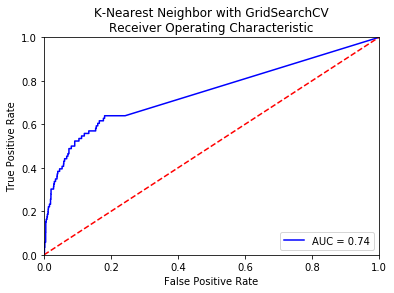

In [50]:
result_auc = getROCAUC(knn_grid, name)

### Results of Classification

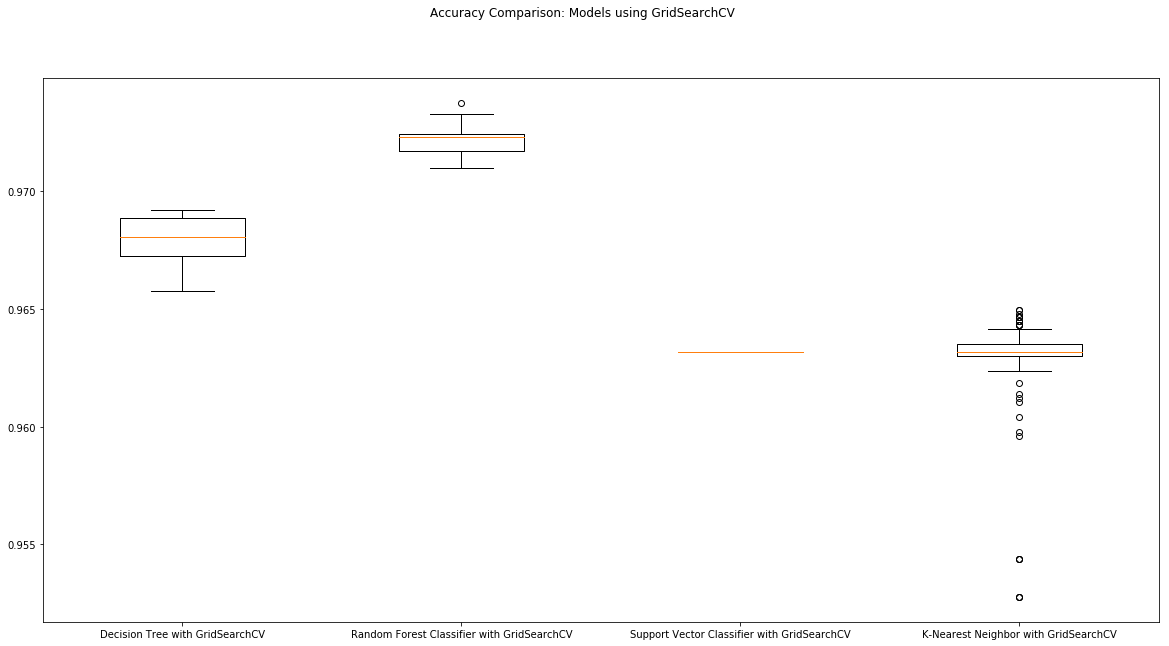

*Best Accuracy and Best Parameters
Logistic Regression with 5 folds CV : ('0.9645', '')
Decision Tree with 10 folds CV : ('0.9610', '')
Decision Tree with GridSearchCV : ('0.9692', {'max_depth': 50, 'min_samples_leaf': 10})
Random Forest Classifier with GridSearchCV : ('0.9738', {'max_depth': 150, 'min_samples_leaf': 1, 'n_estimators': 100})
Support Vector Classifier with GridSearchCV : ('0.9632', {'C': 0.001, 'gamma': 0.001})
K-Nearest Neighbor with GridSearchCV : ('0.9650', {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'})


In [51]:
# boxplot model accuracy comparison
fig = plt.figure(figsize=(20,10))
fig.suptitle('Accuracy Comparison: Models using GridSearchCV')
ax = fig.add_subplot(111)
plt.boxplot(clf_result)
ax.set_xticklabels(clf_name)
plt.show()

print("*Best Accuracy and Best Parameters")
for best in clf_best2:
    print(clf_name2[clf_best2.index(best)], ":", best)

==> The Random Forest Classifier worked best this time with Accuracy 0.9738.

## Clustering - TBD

Unsupervised Learning

## References


Predicting School Performance with Census Income Data  
https://towardsdatascience.com/predicting-school-performance-with-census-income-data-ad3d8792ac97

Gridsearch CV: https://github.com/justmarkham/scikit-learn-videos  
Grid search user guide: https://scikit-learn.org/stable/modules/grid_search.html  
GridSearchCV documentation:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  
RandomizedSearchCV documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html  
Comparing randomized search and grid search: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html  
Random Search for Hyper-Parameter Optimization: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf  
Model result comparison: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/  
Regression:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  
https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f  
k-Neighbors Classifier with GridSearchCV Basics:
https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

Dealing with imbalanced data for classification:
https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data  
k-fold stratified cross-validation with imbalanced classes:  
https://stackoverflow.com/questions/32615429/k-fold-stratified-cross-validation-with-imbalanced-classes

## TODO

-  Conflicting group (known facts), clustering??
    + ex) black >50 , house median: high 

- evaluation metrics
- result explanation
- latex report
- ppt